## Rainy Weekend with Autoencoders
I'm spending a rainy weekend learning about autoencoders using TensorFlow and Keras in Python. I'm particularly interested in one kind of autoencoder called a *variational autoencoder* (because I think it might be useful in my thesis project - more on that in another post) but before I get there, let's back up and nail down some basics...

### *What is autoencoding?*
Autoencoding is much like what it sounds in the sense that the input and 'output' are essentially the same. It's an algorithm for data compression where the functions for compression and decompression are *learned from the data*. The autoencoder learns a compressed representation of the inputs. It's considered more of a *semi-supervised* learning method as opposed to a truly *unsupervised* one since it's not entirely 'targetless'. Instead it learns the targets from the data itself.

Despite all this talk of data compression, autoencoders aren't typically used for that purpose. In practice, you're much more likely to see them being used to preprocess data (as in denoising - think images but it doesn't have to be ;) ) or for dimensionality reduction. In fact, the hidden layers of simple autoencoders are doing something like principal component analysis (PCA), another method traditionally used for dimensionality reduction.

### *Autoencoders*
Generally autoencoders have three parts: an encoder, a decoder, and a 'loss' function that maps one to the other. For the simplest autoencoders - the sort that compress and then reconstruct the original inputs from the compressed representation - we can think of the 'loss' as describing the amount of information lost in the process of reconstruction. Typically when people are talking about autoencoders, they're talking about ones where the encoders and decoders are neural networks (in our case deep convnets). In training the autoencoder, we're optimizing the parameters of the neural networks to minimize the 'loss' (or distance) and we do that by stochastic gradient descent (yet another topic for another post). 

### *The Variational Variety*
There's a bunch of different kinds of autoencoders but for this post I'm going to concentrate on one type called a *variational autoencoder*. Variational autoencoders (VAEs) don't learn to morph the data in and out of a compressed representation of itself like simple, 'vanilla' autoencoders. Instead, they learn the parameters of the probability distribution that the data came from. These types of autoencoders have much in common with latent factor analysis (if you know something about that). The encoder and decoder learn models that are in terms of underlying, *latent* variables. 

VAEs have received a lot of attention in recent years because of their *generative* ability. Since they learn about the distribution the inputs came from, we can sample from that distribution to generate novel data. As well see, VAEs can also be used to cluster data in useful ways.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from scipy.stats import norm

import keras
from keras.layers import Input, Dense, Conv2D, Flatten, Lambda, Reshape, Layer, Conv2DTranspose
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

K.clear_session()

Using TensorFlow backend.
C:\Users\Rebecca\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Let's get the data. I'm working with the MNIST data in the context of the [Digit Recognizer competition on Kaggle](https://www.kaggle.com/c/digit-recognizer/data). I've downloaded the data in csv format so here I'm setting a working directory and loading the data into pandas dataframes. 

In [2]:
import os
import pandas as pd

# Set the working directory
os.chdir('C:\\Users\\Rebecca\\Documents\\NU_MSPA\\python_work\\PREDICT_454\\MNIST') # laptop

train_orig = pd.read_csv('data/train.csv')
test_orig = pd.read_csv('data/test.csv')

train_orig.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's add a 'label' column full of 'missing' to the test dataset.

In [3]:
# create 'label' column in test dataset; rearrange so that columns are in the same order as in train
test_orig['label'] = 'missing'
testCols = test_orig.columns.tolist()
testCols = testCols[-1:] + testCols[:-1]
test = test_orig[testCols]

np.random.seed(555)
train_split = np.random.rand(len(train_orig)) < 0.1
train = train_orig[train_split]
valid = train_orig[~train_split]

train = train_orig
# free up some space and delete train and test
del train_orig, test_orig

test.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,missing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,missing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,missing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,missing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,missing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Split train, valid, and test sets into X's and Y's.

In [4]:
X_train = train.drop(['label'], axis = 1)
X_valid = valid.drop(['label'], axis = 1)
X_test = test.drop(['label'], axis = 1)

y_train = train['label']
y_valid = valid['label']
y_test = test['label']

We can visualize some of the images...

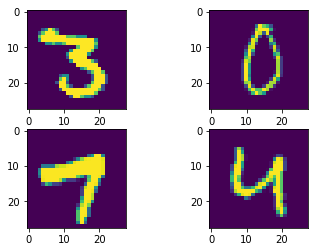

In [5]:
X_train_viz = X_train.values.reshape(-1,28,28,1)

plt.figure(1)
plt.subplot(221)
plt.imshow(X_train_viz[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train_viz[69][:,:,0])

plt.subplot(223)
plt.imshow(X_train_viz[237][:,:,0])

plt.subplot(224)
plt.imshow(X_train_viz[420][:,:,0])
plt.show()

Our variational autoencoder requires three parts:  

##### 1. An encoder network that learns the parameters (mean and variance) of the underlying latent distribution  
This encoder is a CNN with 4 conv2D layers. You'll notice it has two output layers, one for the latent distribution mean (z_mu) and the other for its variance (z_log_sigma)

In [6]:
img_shape = (28, 28, 1)  # for MNIST
batch_size = 16
latent_dim = 2  # these are the mean and the variance of the latent distribution

# Input the image (28x28 nodes)
input_img = Input(shape=img_shape)

# Network architecture is [Conv2D -> relu]*4 -> 
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)    # Required later when decoding

# Flatten -> Dense ->
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Out1: z_mu
z_mu = Dense(latent_dim)(x)

# Out2: z_log_sigma
z_log_sigma = Dense(latent_dim)(x)

AttributeError: module 'keras' has no attribute 'Input'

##### 2. A means of randomly sampling a point from that distribution  
Here we make a function that does the sampling from the latent distribution described by z_mu and z_log_sigma. Because compling the model in Keras requires that everything in our VAE be a layer object, we wrap the sampling function in a Lambda layer.

In [ ]:
# Sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# Turn into layer object
z = Lambda(sampling)([z_mu, z_log_sigma])

##### 3. A decoder network to map that point back into reconstructed image 


In [ ]:
# Input layer takes in the vector z sampled from the latent distribution
decoder_input = Input(K.int_shape(z)[1:])

# Dense layer expands input layer to the same number of pixels as before the encoder flatten step
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

# Reshape into same shape as before the encoder flatten step
x = Reshape(shape_before_flattening[1:])(x)

# Reverse the encoder stack of conv2D layers
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# Decoder model statement
decoder = Model(decoder_input, x)

# Apply decoder to latent distribution sample z
z_decoded = decoder(z)

The VAE is trained using two loss functions:  
1. 'Reconstruction loss' - This is the cross-entropy describing the errors between the samples from the latent distribution and the original inputs.  
2. The Kullback-Liebler divergence between the latent distribution and the prior.  


In [ ]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)  
    
    # This subprocess adds our custom loss to the model
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

Note how the KL divergence acts as a regularization term. Now we instantiate the model...

In [ ]:
# Model statement
vae = Model(inputs=input_img, outputs=y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Now w

In [ ]:
vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(X_valid, None))

In [ ]:
x_valid_encoded = encoder.predict(X_valid, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_valid_encoded[:, 0], x_valid_encoded[:, 1], c=y_valid)
plt.colorbar()
plt.show()